In [33]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from metpy.units import units
from siphon.catalog import TDSCatalog
import numpy as np
import xarray as xr

# Working with GOES Satellite Data
Satellite observations offer a wealth of information that can be enhanced when different channels are combined to generate derived products. In this notebook we'll look at how we plot satellite imagery using Python, add gamma corrections to values to make our images more human readable, and construct a true color image, which will require bringing together three different channels to compute the derived product.

The data are pulled fromt the Unidata THREDDS server https://thredds-test.unidata.ucar.edu/thredds/catalog/catalog.html

For more info related to the GOES-R bands see https://www.goes-r.gov/mission/ABI-bands-quick-info.html

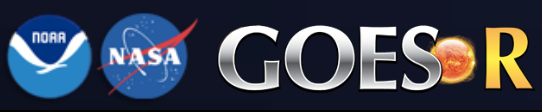
      

In [36]:
# Get datetime from computer closest to now
date = datetime.utcnow()

# Create variables for URL generation
region = 'CONUS'
channel = 2
satellite = 'east'

/var/folders/_4/_0kls59j3ql7ypl24gs0qbk40000gp/T/ipykernel_27099/3362403292.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  date = datetime.utcnow()


In [38]:
def get_satellite_data(date, region='CONUS', channel=2, satellite='east'):
    '''
    This function helps to obtain GOES satellite data by channel from the UCAR THREDDS server.
    
    Input:
      * date - a datetime object specifying the desired time
      * region - the portion of satellite data wanted
        - CONUS (default)
        - fulldisk
      * channel (int value 1 - 16; default is 2)
      * satellite ('east' or 'west'; default is 'east')
    
    Output:
      * xarray DataArray containing the nearest time requested satellite data for the region, channel, and satellite.
    '''
    # We want to match something like:
    # https://thredds-test.unidata.ucar.edu/thredds/catalog/satellite/goes16/GOES16/Mesoscale-1/Channel08/20181113/catalog.html

    # Construct the data_url string
    data_url = (f'https://thredds.ucar.edu/thredds/catalog/satellite/goes/{satellite}/products/'
                f'CloudAndMoistureImagery/{region}/Channel{channel:02d}/'
                f'{date:%Y%m%d}/catalog.xml')

    # Get list of files available for particular day
    cat = TDSCatalog(data_url)

    # Grab dataset for desired time
    dataset = cat.datasets.filter_time_nearest(date, regex=r'_s(?P<strptime>\d{13})', strptime='%Y%j%H%M%S')

    # Open most recent file available
    ds = dataset.remote_access(use_xarray=True,service='OPENDAP').metpy.parse_cf()
    
    return ds

In [40]:
# Call function to get data closest to requested time
ds = get_satellite_data(date, region, channel, satellite)

# specify the valid time from the file
vtime = ds.time.values.astype('datetime64[ms]').astype('O')
print(vtime)

2024-11-12 22:16:15


## Plotting Satellite Observations

Plotting satellite data is not hard, but its native projection is a special satellite projection.

With the large number of points to plot (6000x10000) it is best to plot it in the original projection. Luckily this projection information comes with the metadata contained in the file. We can use MetPy to help us pull out the CartoPy projection without having to construct it ourselves!

To pull out the projection we would use the following format from a DataArray:

`ds.variable.metpy.cartopy_crs`

where `variable` would be replaced by data variable that you are pulling out of the file. For our GOES data that we are working with we would want the `Sectorized_CMI` variable.

In [15]:
# Pull projection from DataArray


# We also need the x (north/south) and y (east/west) axis sweep of the ABI data


### Plot with imshow
Since satellite observations are essentially an image from a special camera, we can use the Matplotlib function `imshow()` to plot the image. In order to plot it on a projection (and be able to plot coastlines, borders, and state boundaries) well need to set a couple of the keyword arguments (`origin`, `extent` and `transform`) to get everything plotted together.

In [68]:
# Set up figure and plotting axes
# plt.figure(1, figsize=(12, 12))
# ax = plt.subplot(111, projection=proj)

# # Use imshow to plot satellite image


# # Add coastlines, borders, and state boundries
# ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='white')
# ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor='white')
# ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='white')

# plt.show()

## Apply Gamma Correction

The image we plotted is a bit dark, this has to do with the difference in which an instrument can sense light versus how our eyes sense light. To make the image more readable to our human eyes, we'll want to apply a gamma correction. Most displays have a decoding gamma of 2.2.

`corrected_value = value^(1/gamma)`.

Read more about gamma correction
at the following links:
[source1](https://en.wikipedia.org/wiki/Gamma_correction) and
[source2](https://www.cambridgeincolour.com/tutorials/gamma-correction.htm).

In [70]:
# Gamma Correction
# plt.figure(1, figsize=(12, 12))
# ax = plt.subplot(111, projection=proj)

# #DRL                    vis channel reflectance ranges from 0 to 1 (vmin,vmax)


# ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='white')
# ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor='white')
# ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='white')

# plt.title('GOES 16 Red Channel Visible', loc='left')
# plt.title(f'Valid: {vtime}', loc='right')

# plt.show()

## GOES-16/17: True Color Imagery

Adapted from Python Example Gallery. Original By: [Brian Blaylock](http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/home.html)
with help from Julien Chastang (UCAR-Unidata).

Additional notebooks analyzing GOES-16 and other data can be found in [Brian's
GitHub repository](https://github.com/blaylockbk/pyBKB_v3/).

This notebook shows how to make a true color image from the GOES-16
Advanced Baseline Imager (ABI) level 2 data. We will plot the image with
matplotlib and Cartopy. The methods shown here are stitched together from the
following online resources:

- [**CIMSS True Color RGB Quick Guide**](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_CIMSSRGB_v2.pdf)
- [ABI Bands Quick Information Guides](https://www.goes-r.gov/education/ABI-bands-quick-info.html)
- [Open Commons Consortium](http://edc.occ-data.org/goes16/python/)
- [GeoNetCast Blog](https://geonetcast.wordpress.com/2017/07/25/geonetclass-manipulating-goes-16-data-with-python-part-vi/)
- [Proj documentation](https://proj4.org/operations/projections/geos.html?highlight=geostationary)

True color images are an RGB composite of the following three channels:

|        --| Wavelength   | Channel | Description   |
|----------|--------------|---------|---------------|
| **Red**  | 0.64 &#181;m |    2    | Red Visible   |
| **Veggie**| 0.86 &#181;m |    3    | Veggie Near-IR|
| **Blue** | 0.47 &#181;m |    1    | Blue Visible  |

For this demo, we use the **Level 2 individual channel data** for the CONUS domain from UCAR THREDDS real-time server.
We'll need to gather each needed channel file individually, and work to align the different resolutions.

GOES-16 data is downloaded from Unidata, but you may also
download data for GOES-16 or 17 files
from NOAA's GOES archive on [Amazon S3](https://aws.amazon.com/public-datasets/goes/).
Brian Blaylock created a [web interface](http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi?source=aws&satellite=noaa-goes16&domain=C&product=ABI-L2-CMIP)
to easily download files from the Amazon archive. For scripted or bulk
downloads, you should use `rclone` or `AWS CLI`. You may also download files
from the [Environmental Data Commons](http://edc.occ-data.org/goes16/getdata/)
and [NOAA
CLASS](https://www.avl.class.noaa.gov/saa/products/search?sub_id=0&datatype_family=GRABIPRD&submit.x=25&submit.y=9).

### L2 Single Channel File names have the following format...

`OR_ABI-L2-CMIPC-M6C02_G16_s20222970011170_e20222970011170_c20222970011170.nc`

`OR`     - Indicates the system is operational

`ABI`    - Instrument type

`L2`     - Level 2 Data

`CMIP`    - Cloud and Moisture Imagery products

`C`      - CONUS file (created every 5 minutes).

`M6`     - Scan mode

`C02`    - Channel 2

`G16`    - GOES-16

`sYYYYJJJHHMMSSZ` - Scan start: 4 digit year, 3 digit day of year (Julian day), hour, minute, second, tenth second

`eYYYYJJJHHMMSSZ` - Scan end

`cYYYYJJJHHMMSSZ` - File Creation
`.nc`    - NetCDF file extension

In [9]:
# Get the red, blue, and veggie bands


Original channel data have two different grid spacings. The red channel (channel 2) has data every 0.5 km, whereas the blue and veggie channels have data every 1 km. If we are going to combine these channels, we'll need to make them the same shape. The simpilest method is to slice the red channel by keeping only every other data point. 

In [52]:
# downscale red channel using every second grid point, isolate data variable


True Color RGB Recipe
---------------------

Color images are a Red-Green-Blue (RGB) composite of three different
channels. To make a "Natural True Color" image we assign the following
channels as our R, G, and B values:

|                      | RED         | Veggie         | BLUE         |
|----------------------|-------------|----------------|--------------|
| **Name**             | Red Visible | Near-IR Veggie | Blue Visible |
| **Wavelength**       | 0.64 µm     | 0.86 µm        | 0.47 µm      |
| **Channel**          | 2           | 3              | 1            |
| **Units**            | Reflectance | Reflectance    | Reflectance  |
| **Range of Values**  | 0-1         | 0-1            | 0-1          |
| **Gamma Correction** | 2.2         | 2.2            | 2.2          |


Some important details to know about...

**Value Range**: The data units of channel 1, 2, and 3 are in reflectance and
have a range of values between 0 and 1. RGB values must also be between 0 and
1.

**True Green**: The "veggie" channel on GOES-16 does not measure
visible green light. Instead, it measures a near-infrared band sensitive to
chlorophyll. We could use that channel in place of green, but it would make
the green in our image appear too vibrant. Instead, we will tone-down the
green channel by interpolating the value to simulate a natural green color.

      TrueGreen = (0.45*RED) + (0.1*Veggie) + (0.45*BLUE)

Now we can begin putting the pieces together...

In [54]:
# Apply range limits for each channel. RGB values must be between 0 and 1


In [56]:
# Apply a gamma correction to the image to correct ABI detector brightness


In [58]:
# Calculate the "True" Green


In [60]:
#G_true

In [62]:
# The RGB array for the true color image


In [64]:
# True Color Image
plt.figure(1, figsize=(12, 12))
ax = plt.subplot(111, projection=proj)


ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='white', lw=0.5)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor='white', lw=0.5)
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='white', lw=0.5)

plt.title('True Color GOES-16 Imagery', loc='left')
plt.title(f'Valid: {vtime} UTC', loc='right')
plt.show()

## Adjust Image Contrast

The color looks a little dull. We can make the colors pop out by adjusting the image
contrast. Adjusting image contrast is easy to do in Photoshop, and also easy
to do in Python.

To understand how contrast works and the calculation behind it, read:
https://www.dfstudios.co.uk/articles/programming/image-programming-algorithms/image-processing-algorithms-part-5-contrast-adjustment/

We are still using the RGB values from the GOES-16 ABI scan.

In [26]:
def contrast_correction(color, contrast):
    """Modify the contrast of an RGB.
    See:
    https://www.dfstudios.co.uk/articles/programming/image-programming-algorithms/image-processing-algorithms-part-5-contrast-adjustment/

    Input:
        color    - an array representing the R, G, and/or B channel
        contrast - contrast correction level
    """
    f = (259 * (contrast + 255)) / (255. * 259 - contrast)
    new_color = f * (color - .5) + .5
    new_color = np.clip(new_color, 0, 1)  # Force value limits 0 through 1.
    return new_color

In [66]:
# Amount of contrast
contrast_amount = 95

# Apply contrast correction


# True Color Image
plt.figure(1, figsize=(12, 12))
ax = plt.subplot(111, projection=proj)


ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='white', lw=0.5)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor='white', lw=0.5)
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='white', lw=0.5)

plt.title(f'GOES-16 True Color Imagery with Contrast {contrast_amount}', loc='left')
plt.title(f'Valid: {vtime} UTC', loc='right')
plt.show()